# **Reconhecimento de Sinalização de Trânsito com TensorFlow**


Esse notebook é uma reescrita de uma versão já criada de reconhecimento de sinalização de trânsito com **TensorFlow**

**Primeiro objetivo: Classificar as sinalizações de trânsito**

In [0]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Permite embutir imagem no notebook
%matplotlib inline

###Testando Matplotlib

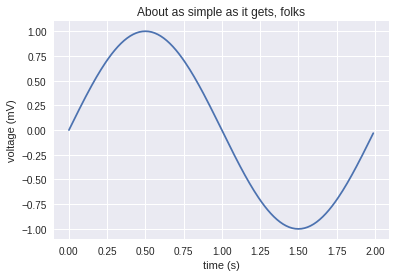

In [2]:
t = np.arange(0.0, 2.0, 0.01)
s = np.sin(1*np.pi*t)
plt.plot(t, s)

plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')
plt.title('About as simple as it gets, folks')
plt.grid(True)
#plt.savefig("test.png")
plt.show()

##Primeiro Passo

O objetivo inicial é a classificação, onde dado um sinal de transito, o modelo deve ser capaz de dizer o tipo. Ex:Placa de pare, limite de velocidade, preparado para parar.(mantenha atenção) 

Primeiro vou testar o carregamento de um arquivo do Google Drive:

In [3]:
from google.colab import drive

'''
Se for necessario usar do montante do GoogleDrive os arquivos pedidos para leitora e escrita
olhe para o contexto informado no parâmetro
'''
drive.mount('/content/gdrive')

with open('/content/gdrive/My Drive/Colab Notebooks/traffic/datasets/BelgiumTS/Learning/foo.txt', 'r') as f:
  print(f.read())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Hello My Drive
Tentando leitura de arquivo


Agora vou testar a leitura de imagem e apresentação da imagem com numpy e matplotlib

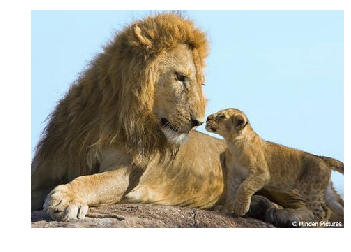

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

img = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/traffic/datasets/BelgiumTS/Learning/lion.jpeg',1)

fig, ax = plt.subplots()
ax.axis('off')#remove as linhas
'''
OpenCv representa as imagens em BGR por isso é preciso converter
RGB para BGR: de onde tirei a resposta
https://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/
'''
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

##Convertendo e Carregando Dados para Treino

###Data Set de Treinamento
Será utilizado o DataSet do Sinal de Trânsito Belga. Para isso é necessário fazer o download dos dados de treino e teste ( http://btsd.ethz.ch/shareddata/). Ele disponibiliza um dataset enorme, mas só vamos utilizar dois da lista ** BelgiumTS for Classification (cropped images)**:

*   BelgiumTSC_Training (171.3MBytes)
*   BelgiumTSC_Testing (76.5MBytes)

Como usar: Faça o download das imagens e coloque no home do seu Google Drive do caminho de pastas:* My Drive/Colab Notebooks/traffic/datasets/BelgiumTS/*

Depois do upload os arquivosm podemos utilizados mesmos arquivamento dentro das seguintes pastas, respectivamente:

    /content/gdrive/My Drive/Colab Notebooks/traffic/datasets/BelgiumTS/Training
    
    /content/gdrive/My Drive/Colab Notebooks/traffic/datasets/BelgiumTS/Testing

Cada uma das duas pastas contém 62 sub-pastar nomeadas em sequencia de 00000 até 00062. As pastas nomeadas representam o código (ou label) e as imagens dentro das pastas são exemplos de cada label.

In [5]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
        print(d)
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "/content/gdrive/My Drive/Colab Notebooks/traffic/"
train_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Training")
test_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Testing")

images, labels = load_data(train_data_dir)

00009
00004
00005
00008
00003
00007
00002
00001
00006
00000
00014
00018
00012
00011
00017
00019
00015
00016
00013
00010
00025
00021
00029
00022
00024
00023
00027
00026
00028
00020
00030
00036
00037
00031
00035
00039
00034
00032
00033
00038
00040
00044
00049
00042
00046
00045
00041
00047
00043
00048
00051
00050
00054
00059
00056
00055
00053
00057
00052
00058
00061
00060


As imagens seram carregadas em duas listas :


*   **Lista de imagens** , cada imagem é representada por uma lista numpy
*   **Lista de labels**, valores inteiros de 0 à 61.



####Explorando o DataSet
Quantos imagens e labels temos?

In [33]:
print("Identificação de Labels(Qtd): {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Identificação de Labels(Qtd): 62
Total Images: 4575


Exibindo a primeira imagem de cada label

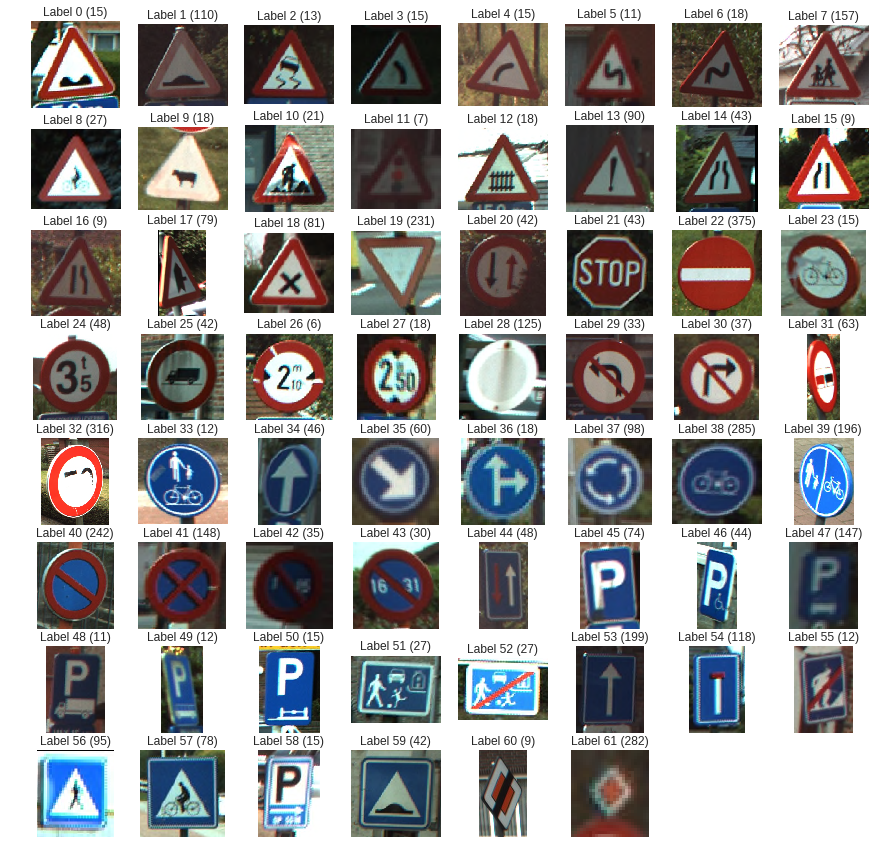

In [7]:
def display_images_and_labels(images, labels):
    """Exibe a primeira imagem de cada label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Escolha a primeira imagem de cada label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # Um grid de 8 linhas x 8 colunas
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

Exibir imagens de uma label expecifica

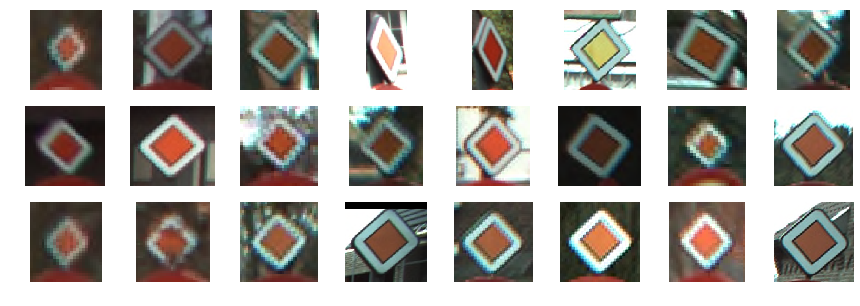

In [8]:
def display_label_images(images, label):
    """Exibe imagens de uma label específica."""
    limit = 24  # apresenta um maximo de 24 imagens
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 linha, por 8 colunas
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 61)

##Como manipular imagens de diferentes tamanhos?

A maoria das redes neurais tem um tamanho da imagem expecificado, porém essa é diferente, uma exceção. Como podemos ver abaixo,
nossas imagens não possuem o mesmo tamanho. O padrão de processamento das imagens é realizado com a compressão das mesmas, porém é necessário garantir que as partes importantes das placas de sinalização não sejam perdidas, isso requer um trabalho manual. Vamos apenas reajustar as imagens para um tamanho fixo e ignorar as distorções causadas pelas disferentes proporções.

In [9]:
"""
image.shape: Isso retorna uma tuple com número de linhas, colunas e canais
image.min(): menor valor dos pixels da imagem
image.max(): maior valor dos pixels da imagem
"""

print("Total de imagens: %s\n"%(len(images)))

print("Exibindo as 5 primeiras:")
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

Total de imagens: 4575

Exibindo as 5 primeiras:
shape: (107, 115, 3), min: 26, max: 255
shape: (108, 120, 3), min: 0, max: 255
shape: (142, 153, 3), min: 12, max: 255
shape: (158, 157, 3), min: 0, max: 255
shape: (200, 223, 3), min: 0, max: 255


Observando informações acima, podemos perceber que as imagens não têm o mesmo tamanho. O próximo passo é reduzir todas as imagens para 32x32, por ser um tamanho grande o bastantes parar reconhecer os sinais de trânsito.

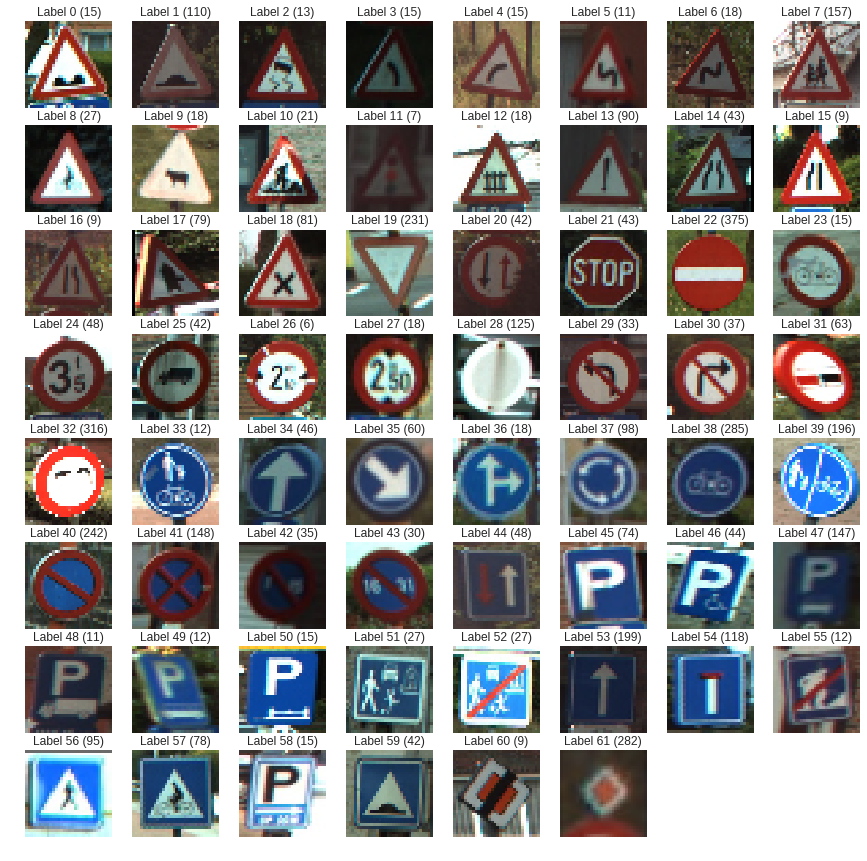

In [10]:

# Transforma as imagens em 32x32
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

Imagens 32:32 não são boas para a visualização humana, mas ainda são reconheciveís. Note que as imagens acima não têm o tamanho real, porque o matplotlob tenta encaixar-los no tamanho do grid. Vamos observar algumas imagens e verificar seu tamanho correto.

In [11]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.1286467907475484, max: 1.0
shape: (32, 32, 3), min: 0.028737745098039523, max: 0.9898897058823526
shape: (32, 32, 3), min: 0.10726677389705931, max: 1.0
shape: (32, 32, 3), min: 0.03534390318627506, max: 0.9785979626225481
shape: (32, 32, 3), min: 0.023184742647058824, max: 0.9930300245098016


Como podemos perceber, o tamanho min e max agora estão em um intervalo de 0.0 à 1.0 e não mais de 0 a 255, como antes da conversão. Esta compressão é realizada pela função automaticamente e é necessário realizar a multiplicação pelo fator 255 para transformá-la no tamanho original.

#Mínimo Modelo Viável

In [12]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [13]:
# Criando um grafo para armazenar o modelo
graph = tf.Graph()

# Criando o modelo dentro do grafo
with graph.as_default():
  
    # Espaços reservados para os inputs e os labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Nivelando os input de: [None, height, width, channels]
    # Para: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Com as camadas todas conectadas. 
    # Gerar um logarítimo de tamanho [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


#Treinamento

In [0]:
# Criar uma sessão para rodar o gráfico que criamos
session = tf.Session(graph=graph)

# O primeiro passo é já inicializar todas as variaveis. 
# Não pe importante o valor de retorno. É nenhum.
_ = session.run([init])

In [15]:
for i in range(201):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

Loss:  4.2849026
Loss:  2.9593072
Loss:  2.4439387
Loss:  2.196258
Loss:  2.0574973
Loss:  1.9631865
Loss:  1.8936104
Loss:  1.838852
Loss:  1.7938144
Loss:  1.7557651
Loss:  1.7230004
Loss:  1.6944393
Loss:  1.6692873
Loss:  1.6469446
Loss:  1.6269506
Loss:  1.6089286
Loss:  1.5925914
Loss:  1.5777098
Loss:  1.5640904
Loss:  1.5515721
Loss:  1.5400203


#Usando o modelo

A sessão de objetos contém os valores the todas as variaveis do nosso modelo. Ex: (O )

In [16]:
# Pega 10 images aleatórias
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Executa o "predicted_labels(labels_predicadas)" op.
'''
Nesse ponto o algoritmo tenta colocar as imagens nas labels que 
acredita que classificação aquela imagem
'''
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]

#Temos um comparativo das labels reais com as previstas
print(sample_labels)
print(predicted)

[1, 61, 38, 13, 61, 34, 37, 59, 19, 1]
[ 1 61 38 56 61 32 37  1 19  1]


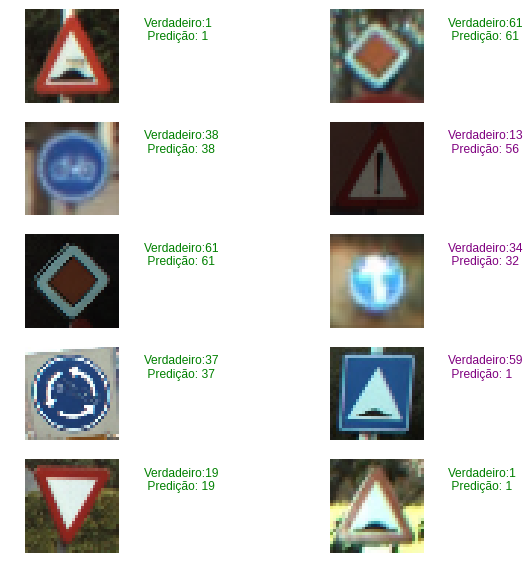

In [30]:
# Exibe as predições e os valores reais da vusualização.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color = 'purple'
    if truth == prediction:
      color = 'green'
    plt.text(40, 10, "Verdadeiro:{0}\n Predição: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

#Avaliação

É hora de visualizarmos os resultados, mas para isso pe necessario mais de um meio para validar a acuracia do nosso modelo. Então, é importante testá-lo com as imagens que não foram vistas. E é ai que o conjunto de dados de valização entra em ação.

In [31]:
# Carrega o dataset test.
test_images, test_labels = load_data(test_data_dir)

00000
00005
00008
00001
00006
00009
00007
00003
00002
00004
00011
00015
00017
00014
00016
00012
00010
00018
00013
00019
00029
00025
00020
00024
00023
00028
00027
00021
00026
00022
00038
00037
00031
00034
00030
00035
00032
00039
00036
00033
00049
00041
00045
00044
00047
00046
00040
00043
00042
00048
00053
00058
00051
00056
00052
00057
00054
00050
00055
00059
00060
00061


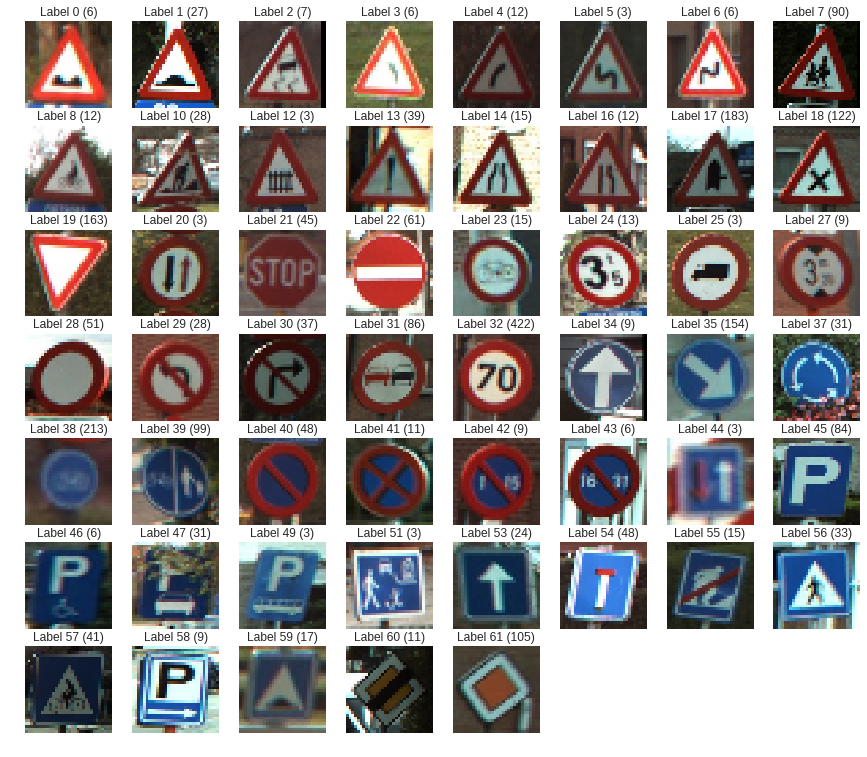

In [34]:

# Transforma as imagens, exatamente igual fizemos no set de treino.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [37]:

# Executa as predições novamento com set de test completo.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calcula quantos matches nos temos.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
#Acuracia de da pelo numero de match pelo numeros de lables testados
accuracy = match_count / len(test_labels)
acurracy_per_cent = 100 * match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))
print("Accuracy per cent: {:.3f}%".format(acurracy_per_cent ))


Accuracy: 0.643
Accuracy per cent: 64.286%


In [0]:
# Fecha a sessão. Isso irá destruir o modelo de treinamento.
session.close()